In [ ]:
import pandas as pd
import numpy as np

df_meta = pd.read_csv('trip_metadata_enriched_sample_2.csv')

# giá trị của thuộc tính fruit_cate
fruit_unique = df_meta['fruit_cate'].unique()
time_range = df_meta['start_time'].min(), df_meta['start_time'].max()
count = df_meta.value_counts()

print(count)
print(fruit_unique)
print(time_range)






trip_id     carrier  start_time                 end_time                   duration_hours  origin  destination  product_id  unit_quantity  weight     service_level  priority  plant_code  expected_delay_min  target_temp_c  distance_km  trip_id_raw   fruit_cate  Route        tpt_days
TRIP_99999  V444_1   2025-08-30 12:10:23+00:00  2025-10-07 02:10:23+00:00  902.0           VNSGN   USCHI        1002        275            0.194035   DTD            high      PLANT03     5                   12.0           36080.0      1.447180e+09  Tomato      VNSGN-USCHI  37.58       1
TRIP_00001  V44_3    2025-05-30 08:47:53+00:00  2025-06-07 03:47:53+00:00  187.0           VNSGN   KRPUS        1002        808            14.300000  CRF            low       PLANT16     6                   12.0           7480.0       1.447296e+09  Tomato      VNSGN-KRPUS  7.79        1
TRIP_00002  V44_3    2024-01-21 19:02:58+00:00  2024-01-25 22:02:58+00:00  99.0            VNHPH   CNSHA        1004        3188           87

In [ ]:
# chuyển đổi 'apple' thành 'orange'
df_meta.loc[df_meta['fruit_cate'] == 'Apple', 'fruit_cate'] = 'Orange'
fruit_unique = df_meta['fruit_cate'].unique()
print(fruit_unique)


['Tomato' 'Pineapple' 'Orange' 'Banana']


In [ ]:
df_meta['start_time'] = pd.to_datetime(df_meta['start_time'])
# Filter for start_time >= '2024-02-01', then sort by start_time, and take the first 12000 entries
df_filtered = df_meta[df_meta['start_time'] >= '2024-02-01'].sort_values(by='start_time').head(12000)
df_filtered.to_csv('12k_trip.csv', index=False)
print(f"Saved {len(df_filtered)} samples to 12k_trip.csv")

Saved 12000 samples to 12k_trip.csv


/tmp/ipython-input-1823767783.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_12k['year_month'] = df_12k['start_time'].dt.to_period('M')


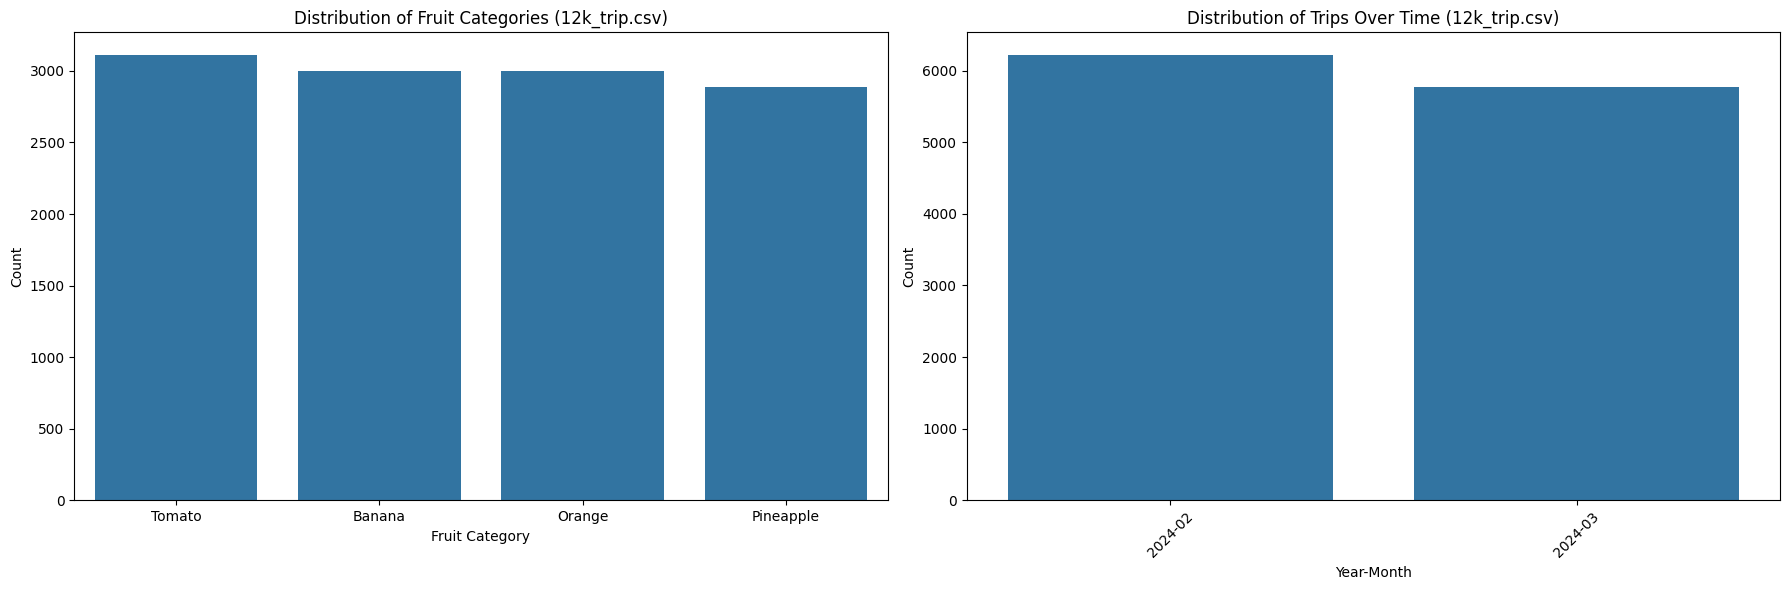


Distribution of fruit_cate (12k_trip.csv):
fruit_cate
Tomato       3114
Banana       3001
Orange       2997
Pineapple    2888
Name: count, dtype: int64

Time range of trips (12k_trip.csv):
Min start time: 2024-02-01 00:01:05+00:00
Max start time: 2024-03-28 06:22:05+00:00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the 12k_trip.csv file
df_12k = pd.read_csv('12k_trip.csv')

# Ensure 'start_time' is in datetime format for df_12k
df_12k['start_time'] = pd.to_datetime(df_12k['start_time'])

# Extract month and year for temporal analysis
df_12k['start_month'] = df_12k['start_time'].dt.month
df_12k['start_year'] = df_12k['start_time'].dt.year

# Create 'year_month' column on df_12k for granular time view
df_12k['year_month'] = df_12k['start_time'].dt.to_period('M')

# Create subplots for better visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot distribution of fruit_cate from df_12k
sns.countplot(data=df_12k, x='fruit_cate', ax=axes[0])
axes[0].set_title('Distribution of Fruit Categories (12k_trip.csv)')
axes[0].set_xlabel('Fruit Category')
axes[0].set_ylabel('Count')

# Plot distribution of trips over time (using df_12k)
sns.countplot(data=df_12k.sort_values('year_month'), x='year_month', ax=axes[1])
axes[1].set_title('Distribution of Trips Over Time (12k_trip.csv)')
axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display basic statistics for fruit_cate from df_12k
print("\nDistribution of fruit_cate (12k_trip.csv):")
print(df_12k['fruit_cate'].value_counts())

# Display basic statistics for time range from df_12k
print("\nTime range of trips (12k_trip.csv):")
print(f"Min start time: {df_12k['start_time'].min()}")
print(f"Max start time: {df_12k['start_time'].max()}")

In [ ]:
chunk_size = 3000
num_parts = (len(df_12k) + chunk_size - 1) // chunk_size # Calculate number of parts needed

for i in range(num_parts):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(df_12k))

    # Get the chunk
    df_chunk = df_12k.iloc[start_idx:end_idx]

    # Define the filename
    filename = f'12k_trip_part_{i + 1}.csv'

    # Save to CSV
    df_chunk.to_csv(filename, index=False)
    print(f"Saved {len(df_chunk)} rows to {filename}")

print(f"Successfully split df_12k into {num_parts} files.")

Saved 3000 rows to 12k_trip_part_1.csv
Saved 3000 rows to 12k_trip_part_2.csv
Saved 3000 rows to 12k_trip_part_3.csv
Saved 3000 rows to 12k_trip_part_4.csv
Successfully split df_12k into 4 files.


# BẮT ĐẦU CHẠY TỪ ĐÂY (NHỚ SỬA TÊN CÁC FILE OUTPUT CHO DỄ PHÂN BIỆT )

In [ ]:
import datetime
import pandas as pd
import numpy as np
from geopy.distance import great_circle
import copy # Cần thiết để sao chép waypoints
from tqdm import tqdm # Import thư viện tqdm

ROUTE_CONFIG = {
    'VNSGN-CNSHA': {
        'waypoints': [
            {'name': 'Cang TP.HCM (Start)', 'lat': 10.75, 'lon': 106.70, 'time_hr': 0.0},
            {'name': 'Vung Tau Exit', 'lat': 10.30, 'lon': 107.10, 'time_hr': 1.5},
            {'name': 'Nam Bien Dong', 'lat': 13.00, 'lon': 110.00, 'time_hr': 15.0},
            {'name': 'Gan Hoang Sa', 'lat': 16.00, 'lon': 112.00, 'time_hr': 25.0},
            {'name': 'Gan Dao Hai Nam', 'lat': 20.00, 'lon': 113.00, 'time_hr': 45.0},
            {'name': 'Eo Bien Luzon/Taiwan', 'lat': 23.00, 'lon': 118.00, 'time_hr': 70.0},
            {'name': 'Gan Ninh Ba', 'lat': 29.00, 'lon': 122.00, 'time_hr': 85.0},
            {'name': 'Cang Thuong Hai (End)', 'lat': 31.23, 'lon': 121.50, 'time_hr': 88.0} # Steaming time: ~3.7 ngày
        ],
        'duration': (168, 216) # Thời gian thực tế: 7-9 ngày
    },
    'VNHPH-CNQZH': {
        'waypoints': [
    {'name': 'T+0h (Depart Haiphong)', 'lat': 20.842740, 'lon': 106.772600, 'time_hr': 0.00},
    {'name': 'T+2h', 'lat': 20.942682, 'lon': 106.992011, 'time_hr': 2.00},
    {'name': 'T+4h', 'lat': 21.042344, 'lon': 107.211715, 'time_hr': 4.00},
    {'name': 'T+6h', 'lat': 21.141723, 'lon': 107.431713, 'time_hr': 6.00},
    {'name': 'T+8h', 'lat': 21.240817, 'lon': 107.652006, 'time_hr': 8.00},
    {'name': 'T+10h','lat': 21.339625, 'lon': 107.872594, 'time_hr': 10.00},
    {'name': 'T+12h','lat': 21.438144, 'lon': 108.093480, 'time_hr': 12.00},
    {'name': 'T+14h','lat': 21.536374, 'lon': 108.314663, 'time_hr': 14.00},
    {'name': 'T+16h','lat': 21.634311, 'lon': 108.536146, 'time_hr': 16.00},
    {'name': 'T+17h (Arrive Qinzhou)',   'lat': 21.683170, 'lon': 108.647000, 'time_hr': 17.00}
]
,
        'duration': (24, 32) # Thời gian thực tế (bao gồm chờ tàu): 1-2 ngày
    },
    'VNSGN-KRPUS': {
        'waypoints': [
{'name': 'Ho Chi Minh Port (Start)', 'lat': 10.77, 'lon': 106.71, 'time_hr': 0.0},
{'name': 'Vung Tau Exit', 'lat': 10.33, 'lon': 107.07, 'time_hr': 2.2},
{'name': 'South China Sea Entry', 'lat': 10.5, 'lon': 108.0, 'time_hr': 5.9},
{'name': 'South China Sea Mid South', 'lat': 13.0, 'lon': 110.0, 'time_hr': 18.7},
{'name': 'South China Sea Central', 'lat': 16.0, 'lon': 112.0, 'time_hr': 33.1},
{'name': 'South China Sea North', 'lat': 19.0, 'lon': 113.5, 'time_hr': 46.6},
{'name': 'Hainan East Approach', 'lat': 20.0, 'lon': 114.0, 'time_hr': 51.1},
{'name': 'Taiwan Strait Entry', 'lat': 23.0, 'lon': 117.0, 'time_hr': 68.1},
{'name': 'Taiwan Strait Mid', 'lat': 24.0, 'lon': 118.0, 'time_hr': 73.7},
{'name': 'Taiwan Strait Exit', 'lat': 25.0, 'lon': 119.5, 'time_hr': 80.9},
{'name': 'East China Sea South', 'lat': 27.0, 'lon': 121.0, 'time_hr': 90.9},
{'name': 'East China Sea Mid', 'lat': 30.0, 'lon': 123.0, 'time_hr': 105.3},
{'name': 'East China Sea North', 'lat': 33.0, 'lon': 126.0, 'time_hr': 122.3},
{'name': 'Busan Approach', 'lat': 34.5, 'lon': 128.0, 'time_hr': 132.3},
{'name': 'Busan Port (End)', 'lat': 35.1, 'lon': 129.05, 'time_hr': 137.1}
],
        'duration': (168, 216) # Thời gian thực tế: 7-9 ngày
    },

    # --- CÁC TUYẾN CẦN CẬP NHẬT DỮ LIỆU ---
    # [PLACEHOLDER] - Vui lòng thay thế waypoints và duration bằng dữ liệu thực tế
    'VNSGN-USMIA': {
        'waypoints': [
    {"name": "Hai Phong Port (Start)", "lat": 20.86, "lon": 106.68, "time_hr": 0.0},
    {"name": "Gulf of Tonkin Exit", "lat": 19.50, "lon": 108.50, "time_hr": 12.0},
    {"name": "South China Sea Central", "lat": 15.00, "lon": 112.00, "time_hr": 48.0},
    {"name": "Singapore Strait", "lat": 1.27, "lon": 103.83, "time_hr": 120.0},
    {"name": "Malacca Strait Exit", "lat": 5.00, "lon": 98.00, "time_hr": 168.0},
    {"name": "Indian Ocean Crossing", "lat": 0.00, "lon": 80.00, "time_hr": 360.0},
    {"name": "Gulf of Aden", "lat": 12.00, "lon": 45.00, "time_hr": 480.0},
    {"name": "Suez Canal Entry", "lat": 29.93, "lon": 32.55, "time_hr": 540.0},
    {"name": "Mediterranean Sea", "lat": 35.00, "lon": 20.00, "time_hr": 600.0},
    {"name": "Gibraltar Strait", "lat": 36.00, "lon": -5.00, "time_hr": 660.0},
    {"name": "Atlantic Ocean Crossing", "lat": 30.00, "lon": -40.00, "time_hr": 840.0},
    {"name": "Caribbean Sea Approach", "lat": 20.00, "lon": -75.00, "time_hr": 960.0},
    {"name": "Miami Port (End)", "lat": 25.77, "lon": -80.20, "time_hr": 1008.0}
],
        'duration': (1024, 1080) # Thời gian thực tế: 38-45 ngày
    },

    'VNHPH-CNSHA': {
        'waypoints': [
    {'name': 'T+0h (Depart Hai Phong)', 'lat': 20.842740, 'lon': 106.772600, 'time_hr': 0.00},
    {'name': 'T+8h',                       'lat': 21.910308, 'lon': 108.093630, 'time_hr': 8.00},
    {'name': 'T+16h',                      'lat': 22.967173, 'lon': 109.434508, 'time_hr': 16.00},
    {'name': 'T+24h',                      'lat': 24.012587, 'lon': 110.796402, 'time_hr': 24.00},
    {'name': 'T+32h',                      'lat': 25.045772, 'lon': 112.180485, 'time_hr': 32.00},
    {'name': 'T+40h',                      'lat': 26.065916, 'lon': 113.587942, 'time_hr': 40.00},
    {'name': 'T+48h',                      'lat': 27.072176, 'lon': 115.019961, 'time_hr': 48.00},
    {'name': 'T+56h',                      'lat': 28.063671, 'lon': 116.477730, 'time_hr': 56.00},
    {'name': 'T+64h',                      'lat': 29.039483, 'lon': 117.962430, 'time_hr': 64.00},
    {'name': 'T+72h',                      'lat': 29.998659, 'lon': 119.475233, 'time_hr': 72.00},
    {'name': 'T+80h',                      'lat': 30.940204, 'lon': 121.017287, 'time_hr': 80.00},
    {'name': 'T+82.41h (Arrive Shanghai)', 'lat': 31.220234, 'lon': 121.487734, 'time_hr': 82.41}
],
        'duration': (120, 168) # Thời gian thực tế: 5-7 ngày
    },
    # [PLACEHOLDER] - USCHI (Chicago) là cảng nội địa. Giả định đi đến USLGB (Los Angeles)
    'VNSGN-USCHI': {
        'waypoints': [
    {"name": "Ho Chi Minh Port (Start)", "lat": 10.75, "lon": 106.70, "time_hr": 0.0},
    {"name": "Vung Tau Exit", "lat": 10.30, "lon": 107.10, "time_hr": 4.0},
    {"name": "South China Sea", "lat": 15.00, "lon": 112.00, "time_hr": 36.0},
    {"name": "Taiwan Strait", "lat": 24.00, "lon": 120.00, "time_hr": 120.0},
    {"name": "East China Sea", "lat": 30.00, "lon": 125.00, "time_hr": 192.0},
    {"name": "Pacific Ocean Crossing", "lat": 35.00, "lon": -160.00, "time_hr": 576.0},
    {"name": "West Coast Approach", "lat": 40.00, "lon": -125.00, "time_hr": 768.0},
    {"name": "San Francisco Bay", "lat": 37.77, "lon": -122.42, "time_hr": 816.0},
    {"name": "Panama Canal Entry", "lat": 9.38, "lon": -79.92, "time_hr": 1104.0},
    {"name": "Gulf of Mexico", "lat": 25.00, "lon": -90.00, "time_hr": 1248.0},
    {"name": "New Orleans Transfer", "lat": 29.95, "lon": -90.07, "time_hr": 1296.0},
    {"name": "Mississippi River System", "lat": 35.00, "lon": -90.00, "time_hr": 1440.0},
    {"name": "Illinois Waterway", "lat": 40.00, "lon": -88.00, "time_hr": 1560.0},
    {"name": "Chicago Port (End)", "lat": 41.88, "lon": -87.62, "time_hr": 1608.0}
],
        'duration': (1500, 1550, 1450) # Thời gian thực tế (chỉ đường biển): 20-24 ngày
    },
    # [PLACEHOLDER]
    'VNHPH-USMIA': {
        'waypoints': [
    {"name": "Hai Phong Port (Start)", "lat": 20.86, "lon": 106.68, "time_hr": 0.0},
    {"name": "Gulf of Tonkin Exit", "lat": 19.50, "lon": 108.50, "time_hr": 12.0},
    {"name": "South China Sea Central", "lat": 15.00, "lon": 112.00, "time_hr": 48.0},
    {"name": "Singapore Strait", "lat": 1.27, "lon": 103.83, "time_hr": 120.0},
    {"name": "Malacca Strait Exit", "lat": 5.00, "lon": 98.00, "time_hr": 168.0},
    {"name": "Indian Ocean Crossing", "lat": 0.00, "lon": 80.00, "time_hr": 360.0},
    {"name": "Gulf of Aden", "lat": 12.00, "lon": 45.00, "time_hr": 480.0},
    {"name": "Suez Canal Entry", "lat": 29.93, "lon": 32.55, "time_hr": 540.0},
    {"name": "Mediterranean Sea", "lat": 35.00, "lon": 20.00, "time_hr": 600.0},
    {"name": "Gibraltar Strait", "lat": 36.00, "lon": -5.00, "time_hr": 660.0},
    {"name": "Atlantic Ocean Crossing", "lat": 30.00, "lon": -40.00, "time_hr": 840.0},
    {"name": "Caribbean Sea Approach", "lat": 20.00, "lon": -75.00, "time_hr": 960.0},
    {"name": "Miami Port (End)", "lat": 25.77, "lon": -80.20, "time_hr": 1008.0}
],
        'duration': (960, 1128) # Thời gian thực tế: 40-47 ngày
    },
    # [PLACEHOLDER]
    'VNSGN-KRINC': {
        'waypoints': [
{'name': 'Ho Chi Minh Port (Start)', 'lat': 10.77, 'lon': 106.71, 'time_hr': 0.0},
{'name': 'Vung Tau Exit', 'lat': 10.33, 'lon': 107.07, 'time_hr': 2.2},
{'name': 'South China Sea Entry', 'lat': 10.5, 'lon': 108.0, 'time_hr': 5.9},
{'name': 'South China Sea Mid South', 'lat': 13.0, 'lon': 110.0, 'time_hr': 18.7},
{'name': 'South China Sea Central', 'lat': 16.0, 'lon': 112.0, 'time_hr': 33.1},
{'name': 'South China Sea North', 'lat': 19.0, 'lon': 113.5, 'time_hr': 46.6},
{'name': 'Hainan East Approach', 'lat': 20.0, 'lon': 114.0, 'time_hr': 51.1},
{'name': 'Taiwan Strait Entry', 'lat': 23.0, 'lon': 117.0, 'time_hr': 68.1},
{'name': 'Taiwan Strait Mid', 'lat': 24.0, 'lon': 118.0, 'time_hr': 73.7},
{'name': 'Taiwan Strait Exit', 'lat': 25.0, 'lon': 119.5, 'time_hr': 80.9},
{'name': 'East China Sea South', 'lat': 27.0, 'lon': 121.0, 'time_hr': 90.9},
{'name': 'East China Sea Mid', 'lat': 30.0, 'lon': 123.0, 'time_hr': 105.3},
{'name': 'East China Sea North', 'lat': 33.0, 'lon': 126.0, 'time_hr': 122.3},
{'name': 'Yellow Sea South', 'lat': 34.0, 'lon': 126.5, 'time_hr': 126.2},
{'name': 'Yellow Sea Mid', 'lat': 35.0, 'lon': 126.0, 'time_hr': 131.2},
{'name': 'Incheon Approach', 'lat': 37.0, 'lon': 126.5, 'time_hr': 141.2},
{'name': 'Incheon Port (End)', 'lat': 37.46, 'lon': 126.64, 'time_hr': 143.3}
],
        'duration': (192, 240) # Thời gian thực tế: 8-10 ngày
    },
    # [PLACEHOLDER]
    'VNDAD-KRPUS': {
        'waypoints': [
{'name': 'Da Nang Port (Start)', 'lat': 16.05, 'lon': 108.22, 'time_hr': 0.0},
{'name': 'Da Nang Channel Exit', 'lat': 15.8, 'lon': 108.5, 'time_hr': 1.3},
{'name': 'South China Sea Entry', 'lat': 16.0, 'lon': 110.0, 'time_hr': 5.6},
{'name': 'South China Sea Central', 'lat': 18.0, 'lon': 112.0, 'time_hr': 15.0},
{'name': 'South China Sea North', 'lat': 21.0, 'lon': 113.0, 'time_hr': 25.0},
{'name': 'Hainan Approach', 'lat': 20.0, 'lon': 110.5, 'time_hr': 23.1},
{'name': 'Taiwan Strait Entry', 'lat': 23.0, 'lon': 117.0, 'time_hr': 40.6},
{'name': 'Taiwan Strait Mid', 'lat': 24.0, 'lon': 118.0, 'time_hr': 46.2},
{'name': 'Taiwan Strait Exit', 'lat': 25.0, 'lon': 119.5, 'time_hr': 53.4},
{'name': 'East China Sea South', 'lat': 27.0, 'lon': 121.0, 'time_hr': 63.4},
{'name': 'East China Sea Mid', 'lat': 30.0, 'lon': 123.0, 'time_hr': 77.8},
{'name': 'East China Sea North', 'lat': 33.0, 'lon': 126.0, 'time_hr': 91.9},
{'name': 'Busan Approach', 'lat': 34.5, 'lon': 128.0, 'time_hr': 101.9},
{'name': 'Busan Port (End)', 'lat': 35.1, 'lon': 129.05, 'time_hr': 105.6}
],
        'duration': (120, 168) # Thời gian thực tế: 5-7 ngày
    }
}


# --- 2. Thông số Mô phỏng ---
GPS_NOISE_LEVEL = 0.005
TIME_JITTER_PERCENT = 0.05
INPUT_CSV_FILE = r'D:\Desktop\Uni\3rd year\BigData\project\Data\Trip data\12k_trip_part_1.csv'
OUTPUT_CSV_FILE = r'D:\Desktop\Uni\3rd year\BigData\project\Data\Bronze_layer\gps_trips_part1.csv'


def calculate_distance_nm(row):
    """Hàm tính khoảng cách great-circle (hải lý)"""
    if pd.isna(row['prev_lat']):
        return 0.0
    point_a = (row['prev_lat'], row['prev_lon'])
    point_b = (row['latitude'], row['longitude'])
    return great_circle(point_a, point_b).nautical

# --- 4. HÀM MÔ PHỎNG (ĐÃ CẬP NHẬT) ---
def simulate_trip(trip_id, fruit_cate, start_time, base_waypoints, realistic_duration_hours, route_key):
    """
    Mô phỏng toàn bộ dữ liệu GPS cho một chuyến đi duy nhất.
    Nhận vào waypoints cơ sở VÀ khoảng thời gian thực tế.
    """

    # SỬA LỖI: Sao chép lộ trình GỐC trước khi thực hiện bất kỳ thay đổi nào
    trip_waypoints = copy.deepcopy(base_waypoints)

    # 4.0. CO GIÃN THỜI GIAN (SLOW STEAMING)
    # Lấy tổng thời gian gốc (ví dụ: 88.0 giờ)
    original_total_time = trip_waypoints[-1]['time_hr']

    # Nếu thời gian gốc = 0 (lỗi dữ liệu), thoát sớm
    if original_total_time == 0:
        print(f"  > LỖI: {trip_id} có lộ trình gốc với thời gian = 0. Bỏ qua.")
        return pd.DataFrame() # Trả về DataFrame rỗng

    # Chọn ngẫu nhiên một tổng thời gian thực tế (ví dụ: 170.5 giờ)
    simulated_total_time = np.random.uniform(
        realistic_duration_hours[0],
        realistic_duration_hours[1]
    )

    # Tính toán tỷ lệ co giãn (ví dụ: 170.5 / 88.0 = 1.93)
    scale_factor = simulated_total_time / original_total_time

    # Áp dụng tỷ lệ này cho TẤT CẢ các mốc thời gian (trừ điểm 0)
    for wp in trip_waypoints:
        wp['time_hr'] = wp['time_hr'] * scale_factor

    # 4.1. TẠO NHIỄU THỜI GIAN (TIME JITTER)
    # (Không cần copy.deepcopy một lần nữa)

    # trip_key_times sẽ bị thay đổi ngẫu nhiên
    trip_key_times = [0.0] # Điểm đầu tiên luôn là 0.0

    for i in range(1, len(trip_waypoints)):
        # Lấy thời gian gốc (ĐÃ ĐƯỢC CO GIÃN)
        base_time = trip_waypoints[i]['time_hr']
        prev_base_time = trip_waypoints[i-1]['time_hr']

        # Khoảng thời gian (đã co giãn) giữa 2 điểm
        segment_duration = base_time - prev_base_time

        # Tạo nhiễu ngẫu nhiên (ví dụ: từ -5% đến +5%)
        jitter = np.random.uniform(-TIME_JITTER_PERCENT, TIME_JITTER_PERCENT)

        # Tính khoảng thời gian mới (thực tế)
        new_segment_duration = segment_duration * (1 + jitter)

        # Thời gian mới = thời gian (đã bị nhiễu) của điểm trước + khoảng thời gian mới
        new_time = trip_key_times[-1] + new_segment_duration

        # Đảm bảo thời gian luôn tăng
        if new_time <= trip_key_times[-1]:
            new_time = trip_key_times[-1] + 0.1 # Thêm 1 khoảng nhỏ

        trip_key_times.append(new_time)

    # Lấy ra các mốc vĩ độ/kinh độ (không đổi từ lộ trình gốc)
    # QUAN TRỌNG: Dùng 'base_waypoints' gốc để lấy vị trí
    key_lats = [wp['lat'] for wp in base_waypoints]
    key_lons = [wp['lon'] for wp in base_waypoints]

    # 4.2. Chạy Nội suy (Interpolation)
    total_hours = int(round(trip_key_times[-1])) # Tổng thời gian mới (đã bị nhiễu)
    target_hours = np.arange(total_hours + 1) # [0, 1, 2, ..., total_hours]

    # Nội suy Vị trí dựa trên Thời gian gốc (để tàu di chuyển đúng)
    # Nội suy Thời gian dựa trên Thời gian đã co giãn (để lấy mẫu)
    original_key_times = [wp['time_hr'] for wp in base_waypoints]

    # Chú ý: Chúng ta nội suy lat/lon dựa trên thời gian GỐC (0-88 giờ)
    # nhưng chúng ta lấy mẫu tại các giờ MỚI (0-170 giờ)
    # SỬA LỖI LOGIC: Phải nội suy lat/lon dựa trên MỐC THỜI GIAN ĐÃ CO GIÃN (trip_key_times)
    # thì vị trí mới khớp với thời gian
    interp_lats = np.interp(target_hours, trip_key_times, key_lats)
    interp_lons = np.interp(target_hours, trip_key_times, key_lons)

    # 4.3. Tạo DataFrame
    df = pd.DataFrame({
        'trip_id': trip_id,
        'fruit_cate': fruit_cate, # Sửa từ fruit_name thành fruit_cate
        'hour': target_hours,
        'latitude_ideal': interp_lats,
        'longitude_ideal': interp_lons,
        'Route': route_key
    })

    # Thêm cột timestamp thực tế
    start_time_dt = pd.to_datetime(start_time)
    df['timestamp'] = df['hour'].apply(lambda h: start_time_dt + datetime.timedelta(hours=h))

    # 4.4. Thêm Nhiễu GPS (Vị trí)
    noise_lat = np.random.normal(0, GPS_NOISE_LEVEL, size=len(df))
    noise_lon = np.random.normal(0, GPS_NOISE_LEVEL, size=len(df))
    df['latitude'] = df['latitude_ideal'] + noise_lat
    df['longitude'] = df['longitude_ideal'] + noise_lon

    # 4.5. Tính toán Tốc độ
    df['prev_lat'] = df['latitude'].shift(1)
    df['prev_lon'] = df['longitude'].shift(1)
    df['distance_nm'] = df.apply(calculate_distance_nm, axis=1)
    df['speed_knots'] = (df['distance_nm'] / 1.0).round(2) # Giả định 1 giờ

    # 4.6. Dọn dẹp
    final_columns = ['trip_id', 'fruit_cate', 'timestamp', 'latitude', 'longitude', 'speed_knots','Route']
    df_final = df[final_columns].copy()
    df_final.loc[0, 'speed_knots'] = 0.0 # Tốc độ tại điểm bắt đầu = 0

    # Print inside the function for individual trip progress (optional, tqdm is better)
    # print(f"  > Đã mô phỏng {ship_id} (Tuyến {row['Route']}), tổng thời gian: {trip_key_times[-1]:.2f} giờ ({len(df_final)} điểm dữ liệu)")

    return df_final

# --- 5. HÀM CHÍNH (ĐÃ CẬP NHẬT) ---
def main():
    print("Bắt đầu mô phỏng hàng loạt chuyến đi...")

    # 5.1. Đọc file CSV đầu vào
    try:
        journeys_df = pd.read_csv(INPUT_CSV_FILE)
    except FileNotFoundError:
        print(f"Không tìm thấy file '{INPUT_CSV_FILE}'. Tạo file mẫu...")

        # Cập nhật file mẫu để chứa cột 'Route'
        sample_data = {
            'trip_id': ['SHIP_001', 'SHIP_002', 'SHIP_003', 'SHIP_004'],
            'fruit_cate': ['Banana', 'Orange', 'Tomato', 'Orange'],
            'start_time': ['2025-10-01T08:00:00', '2025-10-01T12:00:00', '2025-10-02T01:00:00', '2025-10-02T05:00:00'],
            'Route': ['VNSGN-CNSHA', 'VNHPH-CNQZH', 'VNSGN-KRPUS', 'VNSGN-USMIA'] # Thêm cột Route
        }
        sample_df = pd.DataFrame(sample_data)
        sample_df.to_csv(INPUT_CSV_FILE, index=False)

        print(f"Đã tạo file '{INPUT_CSV_FILE}' với dữ liệu mẫu (bao gồm cột 'Route'). Vui lòng chạy lại script.")
        return # Dừng lại để người dùng xem file mẫu

    print(f"Đã đọc {len(journeys_df)} chuyến đi từ {INPUT_CSV_FILE}.")
    if 'Route' not in journeys_df.columns:
        print(f"LỖI: File '{INPUT_CSV_FILE}' của bạn bị thiếu cột 'Route'.")
        print("Vui lòng thêm cột 'Route' (ví dụ: 'VNSGN-CNSHA', 'VNHPH-CNQZH') và chạy lại.")
        return

    # 5.2. Chạy mô phỏng cho từng chuyến
    all_trips_data = [] # List để chứa các DataFrame của mỗi chuyến

    # Sử dụng tqdm để bọc vòng lặp qua các hàng của journeys_df
    for index, row in tqdm(journeys_df.iterrows(), total=len(journeys_df), desc="Đang mô phỏng chuyến đi"):
        # Loại bỏ khoảng trắng ở đầu/cuối VÀ thay thế tất cả khoảng trắng ở giữa
        route_key = row['Route'].replace(" ", "").strip()

        try:
            # Tra cứu cấu hình (waypoints và duration) dựa trên 'Route'
            config = ROUTE_CONFIG[route_key]

            trip_df = simulate_trip(
                trip_id=row['trip_id'],
                fruit_cate=row['fruit_cate'],
                start_time=row['start_time'],
                base_waypoints=config['waypoints'], # Cung cấp waypoints cụ thể
                realistic_duration_hours=config['duration'], # Cung cấp thời gian cụ thể
                route_key=route_key
            )
            if not trip_df.empty: # Chỉ thêm nếu DataFrame không rỗng (trường hợp lỗi thời gian = 0)
                all_trips_data.append(trip_df)

        except KeyError:
            # Bỏ qua nếu không tìm thấy route_key trong ROUTE_CONFIG
            print(f"\n  > CẢNH BÁO: Không tìm thấy cấu hình cho Route '{route_key}' (trip_id: {row['trip_id']}). Bỏ qua.") # Sửa ship_id thành trip_id
            continue
        #except Exception as e:
            #print(f"\n  > LỖI khi xử lý {row['trip_id']} (Route {route_key}): {e}")
            #continue

    # 5.3. Kết hợp và Lưu kết quả
    if not all_trips_data:
        print("\nKhông có dữ liệu nào được mô phỏng thành công.")
        return

    # Ghép tất cả các DataFrame trong list lại thành 1 DataFrame lớn
    final_combined_df = pd.concat(all_trips_data, ignore_index=True)

    # Sắp xếp theo tàu và thời gian cho dễ đọc (tùy chọn)
    final_combined_df = final_combined_df.sort_values(by=['trip_id', 'timestamp'])

    # Lưu ra file CSV tổng
    final_combined_df.to_csv(OUTPUT_CSV_FILE, index=False, encoding='utf-8-sig')

    print(f"\n--- HOÀN TẤT ---")
    print(f"Đã lưu tổng cộng {len(final_combined_df)} điểm dữ liệu của {len(all_trips_data)} chuyến đi vào file:")
    print(f"{OUTPUT_CSV_FILE}")

# --- 6. Thực thi ---
if __name__ == "__main__":
    main()

Bắt đầu mô phỏng hàng loạt chuyến đi...
Đã đọc 3000 chuyến đi từ 12k_trip_part_1.csv.


Đang mô phỏng chuyến đi: 100%|██████████| 3000/3000 [01:18<00:00, 38.31it/s]



--- HOÀN TẤT ---
Đã lưu tổng cộng 1504064 điểm dữ liệu của 3000 chuyến đi vào file:
gps_trips_part1.csv


In [1]:

ROUTE_CONFIG = {
    'VNSGN-CNSHA': {
        'waypoints': [
            {'name': 'Cang TP.HCM (Start)', 'lat': 10.75, 'lon': 106.70, 'time_hr': 0.0},
            {'name': 'Vung Tau Exit', 'lat': 10.30, 'lon': 107.10, 'time_hr': 1.5},
            {'name': 'Nam Bien Dong', 'lat': 13.00, 'lon': 110.00, 'time_hr': 15.0},
            {'name': 'Gan Hoang Sa', 'lat': 16.00, 'lon': 112.00, 'time_hr': 25.0},
            {'name': 'Gan Dao Hai Nam', 'lat': 20.00, 'lon': 113.00, 'time_hr': 45.0},
            {'name': 'Eo Bien Luzon/Taiwan', 'lat': 23.00, 'lon': 118.00, 'time_hr': 70.0},
            {'name': 'Gan Ninh Ba', 'lat': 29.00, 'lon': 122.00, 'time_hr': 85.0},
            {'name': 'Cang Thuong Hai (End)', 'lat': 31.23, 'lon': 121.50, 'time_hr': 88.0} # Steaming time: ~3.7 ngày
        ],
        'duration': (168, 216) # Thời gian thực tế: 7-9 ngày
    },
    'VNHPH-CNQZH': {
        'waypoints': [
    {'name': 'T+0h (Depart Haiphong)', 'lat': 20.842740, 'lon': 106.772600, 'time_hr': 0.00},
    {'name': 'T+2h', 'lat': 20.942682, 'lon': 106.992011, 'time_hr': 2.00},
    {'name': 'T+4h', 'lat': 21.042344, 'lon': 107.211715, 'time_hr': 4.00},
    {'name': 'T+6h', 'lat': 21.141723, 'lon': 107.431713, 'time_hr': 6.00},
    {'name': 'T+8h', 'lat': 21.240817, 'lon': 107.652006, 'time_hr': 8.00},
    {'name': 'T+10h','lat': 21.339625, 'lon': 107.872594, 'time_hr': 10.00},
    {'name': 'T+12h','lat': 21.438144, 'lon': 108.093480, 'time_hr': 12.00},
    {'name': 'T+14h','lat': 21.536374, 'lon': 108.314663, 'time_hr': 14.00},
    {'name': 'T+16h','lat': 21.634311, 'lon': 108.536146, 'time_hr': 16.00},
    {'name': 'T+17h (Arrive Qinzhou)',   'lat': 21.683170, 'lon': 108.647000, 'time_hr': 17.00}
]
,
        'duration': (24, 32) # Thời gian thực tế (bao gồm chờ tàu): 1-2 ngày
    },
    'VNSGN-KRPUS': {
        'waypoints': [
{'name': 'Ho Chi Minh Port (Start)', 'lat': 10.77, 'lon': 106.71, 'time_hr': 0.0},
{'name': 'Vung Tau Exit', 'lat': 10.33, 'lon': 107.07, 'time_hr': 2.2},
{'name': 'South China Sea Entry', 'lat': 10.5, 'lon': 108.0, 'time_hr': 5.9},
{'name': 'South China Sea Mid South', 'lat': 13.0, 'lon': 110.0, 'time_hr': 18.7},
{'name': 'South China Sea Central', 'lat': 16.0, 'lon': 112.0, 'time_hr': 33.1},
{'name': 'South China Sea North', 'lat': 19.0, 'lon': 113.5, 'time_hr': 46.6},
{'name': 'Hainan East Approach', 'lat': 20.0, 'lon': 114.0, 'time_hr': 51.1},
{'name': 'Taiwan Strait Entry', 'lat': 23.0, 'lon': 117.0, 'time_hr': 68.1},
{'name': 'Taiwan Strait Mid', 'lat': 24.0, 'lon': 118.0, 'time_hr': 73.7},
{'name': 'Taiwan Strait Exit', 'lat': 25.0, 'lon': 119.5, 'time_hr': 80.9},
{'name': 'East China Sea South', 'lat': 27.0, 'lon': 121.0, 'time_hr': 90.9},
{'name': 'East China Sea Mid', 'lat': 30.0, 'lon': 123.0, 'time_hr': 105.3},
{'name': 'East China Sea North', 'lat': 33.0, 'lon': 126.0, 'time_hr': 122.3},
{'name': 'Busan Approach', 'lat': 34.5, 'lon': 128.0, 'time_hr': 132.3},
{'name': 'Busan Port (End)', 'lat': 35.1, 'lon': 129.05, 'time_hr': 137.1}
],
        'duration': (168, 216) # Thời gian thực tế: 7-9 ngày
    },

    # --- CÁC TUYẾN CẦN CẬP NHẬT DỮ LIỆU ---
    # [PLACEHOLDER] - Vui lòng thay thế waypoints và duration bằng dữ liệu thực tế
    'VNSGN-USMIA': {
        'waypoints': [
    {"name": "Hai Phong Port (Start)", "lat": 20.86, "lon": 106.68, "time_hr": 0.0},
    {"name": "Gulf of Tonkin Exit", "lat": 19.50, "lon": 108.50, "time_hr": 12.0},
    {"name": "South China Sea Central", "lat": 15.00, "lon": 112.00, "time_hr": 48.0},
    {"name": "Singapore Strait", "lat": 1.27, "lon": 103.83, "time_hr": 120.0},
    {"name": "Malacca Strait Exit", "lat": 5.00, "lon": 98.00, "time_hr": 168.0},
    {"name": "Indian Ocean Crossing", "lat": 0.00, "lon": 80.00, "time_hr": 360.0},
    {"name": "Gulf of Aden", "lat": 12.00, "lon": 45.00, "time_hr": 480.0},
    {"name": "Suez Canal Entry", "lat": 29.93, "lon": 32.55, "time_hr": 540.0},
    {"name": "Mediterranean Sea", "lat": 35.00, "lon": 20.00, "time_hr": 600.0},
    {"name": "Gibraltar Strait", "lat": 36.00, "lon": -5.00, "time_hr": 660.0},
    {"name": "Atlantic Ocean Crossing", "lat": 30.00, "lon": -40.00, "time_hr": 840.0},
    {"name": "Caribbean Sea Approach", "lat": 20.00, "lon": -75.00, "time_hr": 960.0},
    {"name": "Miami Port (End)", "lat": 25.77, "lon": -80.20, "time_hr": 1008.0}
],
        'duration': (1024, 1080) # Thời gian thực tế: 38-45 ngày
    },

    'VNHPH-CNSHA': {
        'waypoints': [
    {'name': 'T+0h (Depart Hai Phong)', 'lat': 20.842740, 'lon': 106.772600, 'time_hr': 0.00},
    {'name': 'T+8h',                       'lat': 21.910308, 'lon': 108.093630, 'time_hr': 8.00},
    {'name': 'T+16h',                      'lat': 22.967173, 'lon': 109.434508, 'time_hr': 16.00},
    {'name': 'T+24h',                      'lat': 24.012587, 'lon': 110.796402, 'time_hr': 24.00},
    {'name': 'T+32h',                      'lat': 25.045772, 'lon': 112.180485, 'time_hr': 32.00},
    {'name': 'T+40h',                      'lat': 26.065916, 'lon': 113.587942, 'time_hr': 40.00},
    {'name': 'T+48h',                      'lat': 27.072176, 'lon': 115.019961, 'time_hr': 48.00},
    {'name': 'T+56h',                      'lat': 28.063671, 'lon': 116.477730, 'time_hr': 56.00},
    {'name': 'T+64h',                      'lat': 29.039483, 'lon': 117.962430, 'time_hr': 64.00},
    {'name': 'T+72h',                      'lat': 29.998659, 'lon': 119.475233, 'time_hr': 72.00},
    {'name': 'T+80h',                      'lat': 30.940204, 'lon': 121.017287, 'time_hr': 80.00},
    {'name': 'T+82.41h (Arrive Shanghai)', 'lat': 31.220234, 'lon': 121.487734, 'time_hr': 82.41}
],
        'duration': (120, 168) # Thời gian thực tế: 5-7 ngày
    },
    # [PLACEHOLDER] - USCHI (Chicago) là cảng nội địa. Giả định đi đến USLGB (Los Angeles)
    'VNSGN-USCHI': {
        'waypoints': [
    {"name": "Ho Chi Minh Port (Start)", "lat": 10.75, "lon": 106.70, "time_hr": 0.0},
    {"name": "Vung Tau Exit", "lat": 10.30, "lon": 107.10, "time_hr": 4.0},
    {"name": "South China Sea", "lat": 15.00, "lon": 112.00, "time_hr": 36.0},
    {"name": "Taiwan Strait", "lat": 24.00, "lon": 120.00, "time_hr": 120.0},
    {"name": "East China Sea", "lat": 30.00, "lon": 125.00, "time_hr": 192.0},
    {"name": "Pacific Ocean Crossing", "lat": 35.00, "lon": -160.00, "time_hr": 576.0},
    {"name": "West Coast Approach", "lat": 40.00, "lon": -125.00, "time_hr": 768.0},
    {"name": "San Francisco Bay", "lat": 37.77, "lon": -122.42, "time_hr": 816.0},
    {"name": "Panama Canal Entry", "lat": 9.38, "lon": -79.92, "time_hr": 1104.0},
    {"name": "Gulf of Mexico", "lat": 25.00, "lon": -90.00, "time_hr": 1248.0},
    {"name": "New Orleans Transfer", "lat": 29.95, "lon": -90.07, "time_hr": 1296.0},
    {"name": "Mississippi River System", "lat": 35.00, "lon": -90.00, "time_hr": 1440.0},
    {"name": "Illinois Waterway", "lat": 40.00, "lon": -88.00, "time_hr": 1560.0},
    {"name": "Chicago Port (End)", "lat": 41.88, "lon": -87.62, "time_hr": 1608.0}
],
        'duration': (1500, 1550, 1450) # Thời gian thực tế (chỉ đường biển): 20-24 ngày
    },
    # [PLACEHOLDER]
    'VNHPH-USMIA': {
        'waypoints': [
    {"name": "Hai Phong Port (Start)", "lat": 20.86, "lon": 106.68, "time_hr": 0.0},
    {"name": "Gulf of Tonkin Exit", "lat": 19.50, "lon": 108.50, "time_hr": 12.0},
    {"name": "South China Sea Central", "lat": 15.00, "lon": 112.00, "time_hr": 48.0},
    {"name": "Singapore Strait", "lat": 1.27, "lon": 103.83, "time_hr": 120.0},
    {"name": "Malacca Strait Exit", "lat": 5.00, "lon": 98.00, "time_hr": 168.0},
    {"name": "Indian Ocean Crossing", "lat": 0.00, "lon": 80.00, "time_hr": 360.0},
    {"name": "Gulf of Aden", "lat": 12.00, "lon": 45.00, "time_hr": 480.0},
    {"name": "Suez Canal Entry", "lat": 29.93, "lon": 32.55, "time_hr": 540.0},
    {"name": "Mediterranean Sea", "lat": 35.00, "lon": 20.00, "time_hr": 600.0},
    {"name": "Gibraltar Strait", "lat": 36.00, "lon": -5.00, "time_hr": 660.0},
    {"name": "Atlantic Ocean Crossing", "lat": 30.00, "lon": -40.00, "time_hr": 840.0},
    {"name": "Caribbean Sea Approach", "lat": 20.00, "lon": -75.00, "time_hr": 960.0},
    {"name": "Miami Port (End)", "lat": 25.77, "lon": -80.20, "time_hr": 1008.0}
],
        'duration': (960, 1128) # Thời gian thực tế: 40-47 ngày
    },
    # [PLACEHOLDER]
    'VNSGN-KRINC': {
        'waypoints': [
{'name': 'Ho Chi Minh Port (Start)', 'lat': 10.77, 'lon': 106.71, 'time_hr': 0.0},
{'name': 'Vung Tau Exit', 'lat': 10.33, 'lon': 107.07, 'time_hr': 2.2},
{'name': 'South China Sea Entry', 'lat': 10.5, 'lon': 108.0, 'time_hr': 5.9},
{'name': 'South China Sea Mid South', 'lat': 13.0, 'lon': 110.0, 'time_hr': 18.7},
{'name': 'South China Sea Central', 'lat': 16.0, 'lon': 112.0, 'time_hr': 33.1},
{'name': 'South China Sea North', 'lat': 19.0, 'lon': 113.5, 'time_hr': 46.6},
{'name': 'Hainan East Approach', 'lat': 20.0, 'lon': 114.0, 'time_hr': 51.1},
{'name': 'Taiwan Strait Entry', 'lat': 23.0, 'lon': 117.0, 'time_hr': 68.1},
{'name': 'Taiwan Strait Mid', 'lat': 24.0, 'lon': 118.0, 'time_hr': 73.7},
{'name': 'Taiwan Strait Exit', 'lat': 25.0, 'lon': 119.5, 'time_hr': 80.9},
{'name': 'East China Sea South', 'lat': 27.0, 'lon': 121.0, 'time_hr': 90.9},
{'name': 'East China Sea Mid', 'lat': 30.0, 'lon': 123.0, 'time_hr': 105.3},
{'name': 'East China Sea North', 'lat': 33.0, 'lon': 126.0, 'time_hr': 122.3},
{'name': 'Yellow Sea South', 'lat': 34.0, 'lon': 126.5, 'time_hr': 126.2},
{'name': 'Yellow Sea Mid', 'lat': 35.0, 'lon': 126.0, 'time_hr': 131.2},
{'name': 'Incheon Approach', 'lat': 37.0, 'lon': 126.5, 'time_hr': 141.2},
{'name': 'Incheon Port (End)', 'lat': 37.46, 'lon': 126.64, 'time_hr': 143.3}
],
        'duration': (192, 240) # Thời gian thực tế: 8-10 ngày
    },
    # [PLACEHOLDER]
    'VNDAD-KRPUS': {
        'waypoints': [
{'name': 'Da Nang Port (Start)', 'lat': 16.05, 'lon': 108.22, 'time_hr': 0.0},
{'name': 'Da Nang Channel Exit', 'lat': 15.8, 'lon': 108.5, 'time_hr': 1.3},
{'name': 'South China Sea Entry', 'lat': 16.0, 'lon': 110.0, 'time_hr': 5.6},
{'name': 'South China Sea Central', 'lat': 18.0, 'lon': 112.0, 'time_hr': 15.0},
{'name': 'South China Sea North', 'lat': 21.0, 'lon': 113.0, 'time_hr': 25.0},
{'name': 'Hainan Approach', 'lat': 20.0, 'lon': 110.5, 'time_hr': 23.1},
{'name': 'Taiwan Strait Entry', 'lat': 23.0, 'lon': 117.0, 'time_hr': 40.6},
{'name': 'Taiwan Strait Mid', 'lat': 24.0, 'lon': 118.0, 'time_hr': 46.2},
{'name': 'Taiwan Strait Exit', 'lat': 25.0, 'lon': 119.5, 'time_hr': 53.4},
{'name': 'East China Sea South', 'lat': 27.0, 'lon': 121.0, 'time_hr': 63.4},
{'name': 'East China Sea Mid', 'lat': 30.0, 'lon': 123.0, 'time_hr': 77.8},
{'name': 'East China Sea North', 'lat': 33.0, 'lon': 126.0, 'time_hr': 91.9},
{'name': 'Busan Approach', 'lat': 34.5, 'lon': 128.0, 'time_hr': 101.9},
{'name': 'Busan Port (End)', 'lat': 35.1, 'lon': 129.05, 'time_hr': 105.6}
],
        'duration': (120, 168) # Thời gian thực tế: 5-7 ngày
    }
}

In [2]:
import requests
import pandas as pd
import numpy as np
import time
import copy
from tqdm import tqdm
import os

In [ ]:


# --- 1. Dữ liệu Lộ trình (Waypoints) ---

if 'ROUTE_CONFIG' not in globals():
    print("LỖI NGHIÊM TRỌNG: Biến 'ROUTE_CONFIG' không tồn tại.")
    print("Vui lòng chạy cell định nghĩa 'ROUTE_CONFIG' (từ Giai đoạn 1) trước khi chạy cell này.")
    raise NameError("ROUTE_CONFIG is not defined")

# --- 2. Cấu hình file và API ---
INPUT_GPS_FILE = r'D:\Desktop\Uni\3rd year\BigData\project\Data\Bronze_layer\gps_trips_part1.csv' # File từ Giai đoạn 1

# NHỚ ĐỔI TÊN CHO DỄ PHÂN BIỆT NHA !!!!!
OUTPUT_ENRICHED_FILE = r'Data\Bronze_layer\enriched_weather_data_part1.csv'

OPEN_METEO_URL = "https://archive-api.open-meteo.com/v1/archive"
HOURLY_PARAMS = "temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,wind_speed_10m,precipitation"

# Cache API (rất quan trọng để không gọi API lặp lại)
weather_cache = {}
api_call_count = 0
total_api_failures = 0 # Đếm số lần thất bại hoàn toàn

# --- 3. HÀM GỌI API (ĐÃ NÂNG CẤP VỚI LOGIC RETRY - GIẢI PHÁP 1) ---
def get_weather_at_point(timestamp, lat, lon):
    """
    Hàm gọi API (có cache) NÂNG CẤP:
    - Tự động retry (thử lại) nếu bị Rate Limit (lỗi 429).
    - Tăng thời gian chờ cơ bản (sleep) để giảm tải API.
    """
    global api_call_count, total_api_failures

    query_lat = round(lat, 2)
    query_lon = round(lon, 2)
    current_time = pd.to_datetime(timestamp)
    date_str = current_time.strftime('%Y-%m-%d')
    target_time_str = current_time.strftime('%Y-%m-%dT%H:00')
    cache_key = (date_str, query_lat, query_lon)

    # 1. Kiểm tra cache
    if cache_key in weather_cache:
        hourly_data = weather_cache[cache_key]
        if not hourly_data:
            return None # Lỗi đã được cache
        # Nếu có, đi thẳng đến Bước 3

    else:
        # 2. CHƯA CÓ TRONG CACHE - GỌI API VỚI LOGIC "THỬ LẠI"
        params = {
            "latitude": query_lat, "longitude": query_lon,
            "start_date": date_str, "end_date": date_str,
            "hourly": HOURLY_PARAMS, "timezone": "UTC"
        }
        max_retries = 5 # Thử lại tối đa 5 lần
        retry_count = 0

        while retry_count < max_retries:
            try:
                response = requests.get(OPEN_METEO_URL, params=params)
                api_call_count += 1 # Đếm số lần *thử* gọi

                # --- KIỂM TRA LỖI API ---

                if response.status_code == 200:
                    # THÀNH CÔNG!
                    data = response.json()
                    weather_cache[cache_key] = data['hourly']

                    time.sleep(0.2)

                    break # Thoát khỏi vòng lặp while

                elif response.status_code == 429:
                    # LỖI 429: BỊ RATE LIMIT (BỊ CHẶN VÌ GỌI NHANH)
                    retry_count += 1
                    # Chờ 15 giây (lần 1), 30 giây (lần 2), ...
                    wait_time = 15 * retry_count
                    print(f"\n[CẢNH BÁO] Bị API Rate Limit (429) tại {cache_key}.")
                    print(f"  Đang chờ {wait_time} giây... (Lần {retry_count}/{max_retries})")
                    time.sleep(wait_time)
                    # Vòng lặp while sẽ tiếp tục

                else:
                    # Lỗi API khác (400, 404, 500)
                    print(f"\n[LỖI API] Lỗi {response.status_code} tại {cache_key}: {response.text}")
                    weather_cache[cache_key] = None # Cache lỗi, không thử lại
                    total_api_failures += 1
                    return None

            except requests.exceptions.RequestException as e:
                # Lỗi kết nối (mất mạng)
                retry_count += 1
                wait_time = 5 * retry_count # Chờ 5s, 10s...
                print(f"\n[LỖI MẠNG] {e}. Đang chờ {wait_time} giây... (Lần {retry_count}/{max_retries})")
                time.sleep(wait_time)
                # Vòng lặp while sẽ tiếp tục

        # Kiểm tra xem vòng lặp while đã thành công hay chưa
        if cache_key not in weather_cache:
            print(f"\n[LỖI NGHIÊM TRỌNG] Thất bại khi gọi API cho {cache_key} sau {max_retries} lần thử.")
            weather_cache[cache_key] = None
            total_api_failures += 1
            return None

    # 3. PHÂN TÍCH DỮ LIỆU (Đã có trong cache)
    hourly_data = weather_cache[cache_key]
    try:
        time_index = hourly_data['time'].index(target_time_str)
        weather_at_hour = {
            'temp': hourly_data['temperature_2m'][time_index],
            'humidity': hourly_data['relative_humidity_2m'][time_index],
            'dew_point': hourly_data['dew_point_2m'][time_index],
            'pressure': hourly_data['surface_pressure'][time_index],
            'wind_speed': hourly_data['wind_speed_10m'][time_index],
            'precipitation': hourly_data['precipitation'][time_index],
        }
        return weather_at_hour
    except (ValueError, KeyError, TypeError, IndexError):
        # Lỗi này xảy ra nếu API trả về data, nhưng data bị rỗng (null)
        # print(f"\nLỗi khi xử lý dữ liệu (JSON) cho {cache_key} vào lúc {target_time_str}.")
        return None

def main_enrich():
    print("Bắt đầu Giai đoạn 2: Làm giàu dữ liệu thời tiết (Tối ưu API & Bộ nhớ)...")
    start_time_total = time.time() # Bắt đầu đếm giờ

    # 4.1. Đọc Dữ liệu (File Giai đoạn 1)
    try:
        df_gps = pd.read_csv(INPUT_GPS_FILE, parse_dates=['timestamp'])
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file '{INPUT_GPS_FILE}'.")
        print("Vui lòng chạy Giai đoạn 1 (mô phỏng GPS) trước.")
        return
    except Exception as e:
        print(f"Lỗi khi đọc file CSV: {e}")
        return

    print(f"Đã đọc {len(df_gps)} điểm GPS từ '{INPUT_GPS_FILE}'.")

    # Kiểm tra cột 'Route' (từ Giai đoạn 1)
    if 'Route' not in df_gps.columns:
        print(f"Lỗi: File '{INPUT_GPS_FILE}' không chứa cột 'Route'.")
        print("Vui lòng chạy lại Giai đoạn 1 với logic MERGE chính xác.")
        return

    # Làm sạch Route key (để đảm bảo)
    df_gps['Route'] = df_gps['Route'].str.replace(" ", "").str.strip()
    df_gps = df_gps.dropna(subset=['Route']) # Bỏ qua các chuyến null

    # --- [LOGIC MỚI] GHI-NỐI-TIẾP VÀ KHÔI PHỤC ---

    processed_trip_ids = set()
    file_exists = os.path.exists(OUTPUT_ENRICHED_FILE)

    if file_exists:
        print(f"Phát hiện file output: {OUTPUT_ENRICHED_FILE}. Đang đọc các trip_id đã xử lý...")
        try:
            # Đọc *chỉ* cột 'trip_id' để tiết kiệm bộ nhớ tối đa
            df_existing = pd.read_csv(OUTPUT_ENRICHED_FILE, usecols=['trip_id'])
            processed_trip_ids = set(df_existing['trip_id'].unique())
            print(f"Đã tìm thấy {len(processed_trip_ids)} trips đã xử lý. Sẽ bỏ qua các trips này.")
        except Exception as e:
            # Nếu file lỗi (ví dụ: file rỗng, hoặc file bị hỏng), ta sẽ ghi đè
            print(f"Lỗi khi đọc file cũ '{OUTPUT_ENRICHED_FILE}': {e}. Sẽ bắt đầu ghi file mới.")
            file_exists = False # Coi như file không tồn tại/bị lỗi

    # Biến cờ để ghi header
    # Nếu file CHƯA tồn tại (hoặc bị lỗi), ta sẽ 'write' (is_first_trip = True)
    # Nếu file đã tồn tại và có dữ liệu, ta sẽ 'append' (is_first_trip = False)
    is_first_trip = not file_exists

    total_points_processed_this_run = 0 # Đếm số điểm cho *lần chạy này*
    new_trips_processed_this_run = 0   # Đếm số trip cho *lần chạy này*

    # --- HẾT [LOGIC MỚI] ---

    # 4.2. Lặp qua từng chuyến tàu (Trip)
    df_gps_grouped = df_gps.groupby('trip_id')

    print(f"Tổng cộng có {len(df_gps_grouped)} chuyến đi. Đã xử lý trước đó: {len(processed_trip_ids)}.")

    for trip_id, trip_df in tqdm(df_gps_grouped, total=len(df_gps_grouped), desc="Xử lý thời tiết các chuyến"):

        # --- [LOGIC MỚI] KIỂM TRA ĐIỀU KIỆN BỎ QUA ---
        if trip_id in processed_trip_ids:
            continue # Bỏ qua trip này, đã xử lý rồi
        # --- HẾT [LOGIC MỚI] ---


        # (Logic nội suy 1 chuyến đi - giữ nguyên)
        # 1. Lấy Route Key cho chuyến đi này
        route_key = trip_df['Route'].iloc[0]

        # 2. Tra cứu cấu hình (config) cho route_key này
        config = ROUTE_CONFIG.get(route_key)
        if not config:
            # print(f"\n   > CẢNH BÁO: Không tìm thấy cấu hình Waypoint cho Route '{route_key}' (Trip: {trip_id}). Bỏ qua.")
            continue

        # 3. Lấy các "điểm neo" (KEY_HOURS) GỐC
        route_waypoints = config['waypoints']
        KEY_HOURS = [wp['time_hr'] for wp in route_waypoints]

        if not KEY_HOURS or (len(KEY_HOURS) > 0 and route_waypoints[-1]['time_hr'] == 0):
            # print(f"\n   > CẢNH BÁO: Dữ liệu Waypoint cho Route '{route_key}' không hợp lệ. Bỏ qua.")
            continue

        # 4. Lấy thời tiết tại các "điểm neo"
        key_weather_frames = {
            'timestamp_hours': [], 'temp': [], 'humidity': [], 'dew_point': [],
            'pressure': [], 'wind_speed': [], 'precipitation': []
        }
        start_time_trip = trip_df['timestamp'].min()

        for base_hour in KEY_HOURS:
            # Tìm điểm GPS thực tế gần nhất với mốc thời gian GỐC
            target_timestamp = start_time_trip + pd.Timedelta(hours=base_hour)
            key_point_row = trip_df.iloc[(trip_df['timestamp'] - target_timestamp).abs().argmin()]

            lat = key_point_row['latitude']
            lon = key_point_row['longitude']
            timestamp = key_point_row['timestamp']

            # Tính mốc giờ THỰC TẾ (đã bị co giãn/nhiễu)
            actual_hour_relative = (timestamp - start_time_trip).total_seconds() / 3600.0

            weather_data = get_weather_at_point(timestamp, lat, lon)

            if weather_data:
                key_weather_frames['timestamp_hours'].append(actual_hour_relative)
                for key in weather_data:
                    # Đảm bảo key tồn tại trong dict (phòng trường hợp API thay đổi)
                    if key in key_weather_frames:
                        key_weather_frames[key].append(weather_data[key])

        # 5. Nội suy (Interpolate)
        new_trip_df = trip_df.copy() # Rất quan trọng: làm việc trên bản copy

        # Tạo trục X (giờ) cho tất cả các điểm
        new_trip_df['timestamp_hours'] = (new_trip_df['timestamp'] - start_time_trip).dt.total_seconds() / 3600.0
        target_hours_relative = new_trip_df['timestamp_hours']

        # Lấy các điểm neo (trục X và Y)
        known_hours_relative = key_weather_frames['timestamp_hours']
        sorted_indices = np.argsort(known_hours_relative)
        known_hours_relative_sorted = np.array(known_hours_relative)[sorted_indices]

        # Đổi tên param -> tên cột
        param_to_col_map = {
            'temp': 'temperature_C', 'humidity': 'humidity_%', 'dew_point': 'dew_point_C',
            'pressure': 'pressure_hPa', 'wind_speed': 'wind_speed_kmh', 'precipitation': 'precipitation_mm'
        }

        if len(known_hours_relative_sorted) < 2:

            for col_name in param_to_col_map.values():
                new_trip_df[col_name] = np.nan
        else:
            # Chạy nội suy cho từng tham số thời tiết
            for param, output_col in param_to_col_map.items():
                # Đảm bảo số lượng điểm dữ liệu khớp nhau
                if param in key_weather_frames and len(key_weather_frames[param]) == len(sorted_indices):
                    known_values_sorted = np.array(key_weather_frames[param])[sorted_indices]

                    new_trip_df[output_col] = np.interp(
                        target_hours_relative,
                        known_hours_relative_sorted,
                        known_values_sorted
                    )
                else:
                    # (In ra cảnh báo nếu số lượng không khớp, có thể do lỗi API)
                    # print(f"   > Cảnh báo: Thiếu dữ liệu cho '{param}' trong chuyến {trip_id}.")
                    new_trip_df[output_col] = np.nan

        # Xóa cột tạm thời TRƯỚC KHI LƯU
        new_trip_df = new_trip_df.drop(columns=['timestamp_hours'], errors='ignore')

        # --- 4.3. GHI-NỐI-TIẾP (Append to File) ---
        # Logic này vẫn chính xác vì cờ 'is_first_trip' đã được đặt đúng ở [LOGIC MỚI]
        if is_first_trip:
            # Lần đầu tiên (của file): Ghi (write) với header
            new_trip_df.to_csv(OUTPUT_ENRICHED_FILE, index=False, mode='w', header=True, encoding='utf-8-sig')
            is_first_trip = False # Lật cờ
        else:
            # Những lần sau: Nối (append) không có header
            new_trip_df.to_csv(OUTPUT_ENRICHED_FILE, index=False, mode='a', header=False, encoding='utf-8-sig')

        total_points_processed_this_run += len(new_trip_df)
        new_trips_processed_this_run += 1 # Đếm số trip mới đã xử lý

        # (Tùy chọn: Giải phóng bộ nhớ)
        del new_trip_df
        del trip_df

    # --- 5. Kết thúc ---
    end_time_total = time.time()
    total_duration_minutes = (end_time_total - start_time_total) / 60

    print(f"\n--- HOÀN TẤT GIAI ĐOẠN 2 ---")
    print(f"Tổng thời gian chạy: {total_duration_minutes:.2f} phút.")
    print(f"Tổng số lượt thử gọi API (trong lần chạy này): {api_call_count}")
    print(f"Tổng số lượt gọi API thất bại (trong lần chạy này): {total_api_failures}")
    print(f"Đã bỏ qua {len(processed_trip_ids)} chuyến đi đã xử lý trước đó.")
    print(f"Đã xử lý và lưu MỚI {total_points_processed_this_run} điểm dữ liệu (từ {new_trips_processed_this_run} chuyến) vào file:")
    print(f"{OUTPUT_ENRICHED_FILE}")

main_enrich()

Bắt đầu Giai đoạn 2: Làm giàu dữ liệu thời tiết (Tối ưu API & Bộ nhớ)...
Đã đọc 1504064 điểm GPS từ 'gps_trips_part1.csv'.
Phát hiện file output: enriched_weather_data_3000_part1.csv. Đang đọc các trip_id đã xử lý...
Đã tìm thấy 2778 trips đã xử lý. Sẽ bỏ qua các trips này.
Tổng cộng có 3000 chuyến đi. Đã xử lý trước đó: 2778.


Xử lý thời tiết các chuyến: 100%|██████████| 3000/3000 [46:34<00:00,  1.07it/s]  


--- HOÀN TẤT GIAI ĐOẠN 2 ---
Tổng thời gian chạy: 46.91 phút.
Tổng số lượt thử gọi API (trong lần chạy này): 2760
Tổng số lượt gọi API thất bại (trong lần chạy này): 0
Đã bỏ qua 2778 chuyến đi đã xử lý trước đó.
Đã xử lý và lưu MỚI 132167 điểm dữ liệu (từ 222 chuyến) vào file:
enriched_weather_data_3000_part1.csv
